In [1]:
from src.models.lbcnn.lbc_unet import SkinnySmallUNetLBP
import matplotlib.pyplot as plt
from src.datasets.ice import IceForVisualizing
import torch
import numpy as np
import os
from torch import nn
from src.metrics.segmentation import _fast_hist, per_class_pixel_accuracy, jaccard_index
import torch.nn.functional as F

In [2]:
def eval_model(model: nn.Module, checkpoint_path: str, img_number: int, mobile: bool = False) -> None:
    model.load_state_dict(torch.load(checkpoint_path, map_location=device))
    model.train()
    out = nn.Softmax(dim=1)

    mask_list, pred_list = [], []

    img = val_set[img_number]['image'].to(device=device).unsqueeze(0)
    mask = val_set[img_number]['mask'].to(device=device, dtype=torch.long).unsqueeze(0)
    img_orig = val_set[img_number]['img_orig'].to(device=device)

    if mobile:
        imgs = torch.stack([img, img], dim=0).squeeze(1)
        with torch.no_grad():
            output = model(imgs)['out']
        sftmx = out(output)
        argmx = torch.argmax(sftmx, dim=1)[0].unsqueeze(0)
        hist = _fast_hist(mask.squeeze(0), argmx.to(dtype=torch.long), 3)
        iou = jaccard_index(hist)[0]
        acc = per_class_pixel_accuracy(hist)[0]
        loss = F.cross_entropy(output[0].unsqueeze(0), mask.squeeze(1)).detach().item()
    else:
        with torch.no_grad():
            output = model(img)
        sftmx = out(output)
        argmx = torch.argmax(sftmx, dim=1)
        hist = _fast_hist(mask.squeeze(0), argmx.to(dtype=torch.long), 3)
        iou = jaccard_index(hist)[0]
        acc = per_class_pixel_accuracy(hist)[0]
        loss = F.cross_entropy(output, mask.squeeze(1)).detach().item()
    print(model.__class__.__name__, iou)
    
    img_np = img.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    img_orig_np = img_orig.permute(0, 2, 1).detach().cpu().numpy()
    mask_np = mask.squeeze(0).permute(1, 2, 0).detach().cpu().numpy()
    argmx_np = argmx.permute(1, 2, 0).detach().cpu().numpy()
    return img_orig_np, mask_np, argmx_np

def plot_example(ax, img, is_img=False, x_label=None, y_label=None):
    ax.imshow(img, cmap='gray')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis=u'both', which=u'both',length=0)
#     ax.axis('off')
    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label) # , rotation=0)

In [6]:
IMG_NUMBER = 8
EPOCH = 80

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
data_dir = '/home/dsola/repos/PGA-Net/data/'
batch_size = 1
img_crop = 256
img_scale = 0.35

val_set = IceForVisualizing(os.path.join(data_dir, 'imgs'), os.path.join(data_dir, 'masks'),
              os.path.join(data_dir, 'txt_files'), 'val', img_scale, img_crop)

SkinnySmallUNetLBP tensor(0.8387, device='cuda:0')
SkinnySmallUNetLBP tensor(0.8553, device='cuda:0')
SkinnySmallUNetLBP tensor(0.7104, device='cuda:0')
SkinnySmallUNetLBP tensor(0.7687, device='cuda:0')
SkinnySmallUNetLBP tensor(0.8289, device='cuda:0')


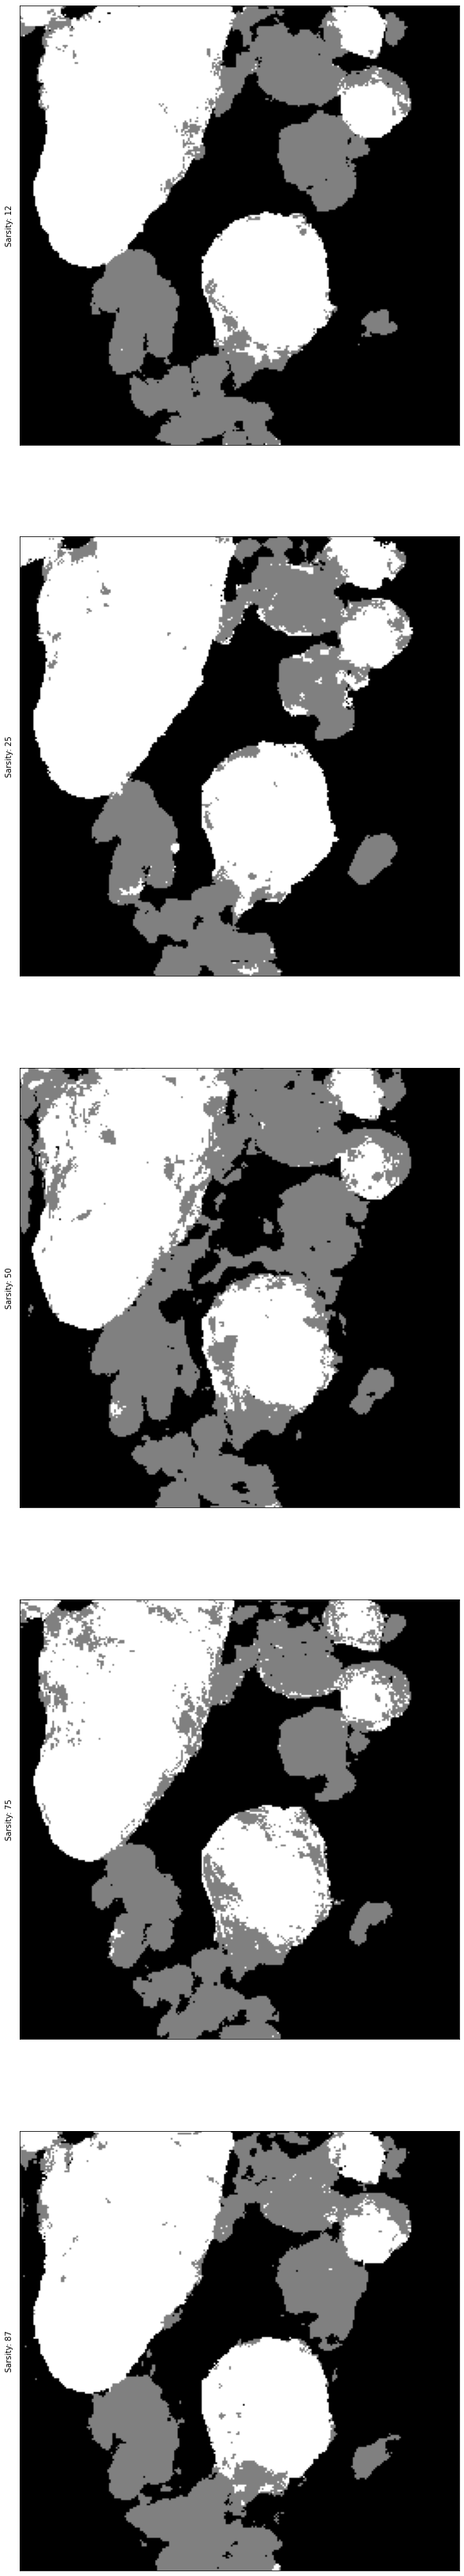

In [7]:
checkpoint_dict = {
    12: 'skinny_small_lbc_unet_sparcity_12',
    25: 'skinny_small_lbc_unet_sparcity_25',
    50: 'skinny_small_lbc_unet_sparcity_50',
    75: 'skinny_small_lbc_unet_sparcity_75',
    87: 'skinny_small_lbc_unet_sparcity_87',
}

fig, axs = plt.subplots(5,1, figsize=(10,60))

for i, sparsity in enumerate(checkpoint_dict.keys()):
    model = SkinnySmallUNetLBP(3,3).to(device)
    checkpoint_path = f'/home/dsola/repos/PGA-Net/checkpoints/{checkpoint_dict[sparsity]}/epoch{EPOCH}.pth'
    img_orig_np, mask_np, argmx_np = eval_model(model=model, checkpoint_path=checkpoint_path, img_number=IMG_NUMBER)
    plot_example(axs[i], argmx_np, is_img=False, x_label=None, y_label=f'Sarsity: {sparsity}')

In [5]:
model.inc.conv_lbp.weight

Parameter containing:
tensor([[[[ 1., -1.,  1.],
          [-1.,  1., -1.],
          [-1.,  1., -1.]],

         [[ 1.,  1.,  1.],
          [-1.,  1.,  1.],
          [ 1., -1.,  1.]],

         [[ 1., -1., -1.],
          [ 1.,  1., -1.],
          [-1., -1., -1.]]],


        [[[ 0., -1.,  0.],
          [-1.,  1.,  1.],
          [-1., -1., -1.]],

         [[ 1.,  1., -1.],
          [ 0., -1.,  1.],
          [ 1.,  1.,  1.]],

         [[ 0.,  0., -1.],
          [ 1., -1., -1.],
          [ 1.,  1.,  1.]]],


        [[[-1., -1.,  1.],
          [ 1., -1.,  0.],
          [ 0.,  1.,  1.]],

         [[ 0., -1.,  0.],
          [-1.,  0., -1.],
          [-1.,  0.,  1.]],

         [[ 1., -1., -1.],
          [ 1., -1.,  1.],
          [ 1., -1.,  1.]]]], device='cuda:0')